#### Notebook to extract the data in a shapefile from a NetCDF data.
#### The 1 year average of a variable in California is found from the NetCDF grid with a resolution of 0.75 X 0.75 

In [1]:
## conda env Weather_Prediction

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import xarray as xr
import regionmask

#### The netcdf file that we will load is of CONtinental USA (CONUS). Its for the year 2010 and every 3 hours. This data is downloaded from CAMS link https://ads.atmosphere.copernicus.eu/datasets/cams-global-reanalysis-eac4?tab=download. Only 2 variables have been considered for ease for now. 

In [2]:
data = xr.open_dataset("data_sfc.nc")
data

<xarray.Dataset> Size: 63MB
Dimensions:     (valid_time: 2920, latitude: 34, longitude: 79)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 23kB 2010-01-01 ... 2010-12-31T21...
  * latitude    (latitude) float64 272B 48.75 48.0 47.25 ... 25.5 24.75 24.0
  * longitude   (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
Data variables:
    d2m         (valid_time, latitude, longitude) float32 31MB ...
    t2m         (valid_time, latitude, longitude) float32 31MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-30T01:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
## lets resample the data to 1 year, as our life expectency is also that of 1 year

resampled_1year = data.resample(valid_time='1YE').mean(dim='valid_time')
resampled_1year

<xarray.Dataset> Size: 22kB
Dimensions:     (valid_time: 1, latitude: 34, longitude: 79)
Coordinates:
  * latitude    (latitude) float64 272B 48.75 48.0 47.25 ... 25.5 24.75 24.0
  * longitude   (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
  * valid_time  (valid_time) datetime64[ns] 8B 2010-12-31
Data variables:
    d2m         (valid_time, latitude, longitude) float32 11kB 280.2 ... 293.5
    t2m         (valid_time, latitude, longitude) float32 11kB 282.7 ... 297.4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-30T01:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
## convert to dataframe for visualizing. This step is not required

df=resampled_1year.to_dataframe()
df

d2m         t2m
valid_time latitude longitude                        
2010-12-31 48.75    -125.00    280.158722  282.717682
                    -124.25    279.476868  282.623596
                    -123.50    279.457245  283.005524
                    -122.75    279.182251  282.910004
                    -122.00    276.495148  280.681885
...                                   ...         ...
           24.00    -69.50     293.573669  297.577881
                    -68.75     293.532562  297.538727
                    -68.00     293.503845  297.490417
                    -67.25     293.475891  297.458191
                    -66.50     293.459106  297.428833

[2686 rows x 2 columns]

In [5]:
## Lets load the state shapefile

SHAPE_PATH = os.path.join("State_shapefile",'cb_2018_us_state_500k.shp')
states_gdf = gpd.read_file(SHAPE_PATH)
states_gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [6]:
## select california state for now

cali_aoi = states_gdf[states_gdf.NAME == "California"]


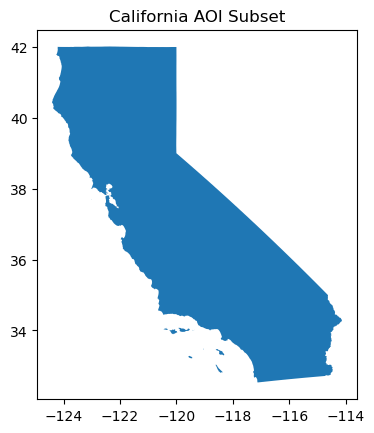

In [7]:
# This is the area of interest (AOI). You only want to calculate summary values for
# pixels within his AOI

f, ax = plt.subplots()
cali_aoi.plot(ax=ax)
ax.set(title="California AOI Subset")

plt.show()

In [8]:
# Create a 3d mask - this contains the true / false values identifying pixels
# inside vs outside of the mask region
cali_mask = regionmask.mask_3D_geopandas(cali_aoi,
                                         resampled_1year.longitude,
                                         resampled_1year.latitude)
cali_mask

<xarray.DataArray 'mask' (region: 1, latitude: 34, longitude: 79)> Size: 3kB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * latitude   (latitude) float64 272B 48.75 48.0 47.25 46.5 ... 25.5 24.75 24.0
  * longitude  (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
  * region     (region) int64 8B 16
Attributes:
    standard_name:  region

In [10]:
# Apply the mask for California to the data
masked_region = resampled_1year.where(cali_mask)
masked_region

<xarray.Dataset> Size: 22kB
Dimensions:     (valid_time: 1, latitude: 34, longitude: 79, region: 1)
Coordinates:
  * latitude    (latitude) float64 272B 48.75 48.0 47.25 ... 25.5 24.75 24.0
  * longitude   (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
  * valid_time  (valid_time) datetime64[ns] 8B 2010-12-31
  * region      (region) int64 8B 16
Data variables:
    d2m         (valid_time, latitude, longitude, region) float32 11kB nan .....
    t2m         (valid_time, latitude, longitude, region) float32 11kB nan .....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-30T01:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
df=masked_region.to_dataframe()
df

d2m  t2m
valid_time latitude longitude region          
2010-12-31 48.75    -125.00   16      NaN  NaN
                    -124.25   16      NaN  NaN
                    -123.50   16      NaN  NaN
                    -122.75   16      NaN  NaN
                    -122.00   16      NaN  NaN
...                                   ...  ...
           24.00    -69.50    16      NaN  NaN
                    -68.75    16      NaN  NaN
                    -68.00    16      NaN  NaN
                    -67.25    16      NaN  NaN
                    -66.50    16      NaN  NaN

[2686 rows x 2 columns]

In [16]:
## this is important where grouping can be done by valid time, and by region; along some dimension
## the dimension over here is latitude and longitude
## replacing valid_time by region will not make any difference as there is only one value.

summary = masked_region.groupby("valid_time").mean(["latitude", "longitude"])
summary.to_dataframe()

,,d2m,t2m
valid_time,region,,
2010-12-31,16,276.480713,287.42746


In [22]:
summary_2 = two_months.groupby("region").mean(["latitude", "longitude","valid_time"])
summary_2.to_dataframe()

,d2m,t2m
region,,
16,276.480713,287.42746


In [23]:
## convert to dataframe so that merging is easy

df1=pd.DataFrame(states_gdf)
type(df1)

pandas.core.frame.DataFrame

In [24]:
df2=summary_2.to_dataframe()
type(df2)

pandas.core.frame.DataFrame

In [27]:
df = pd.merge(df1, df2, left_index=True, right_index=True, how='left')
df.head(17)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,d2m,t2m
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",NaN,NaN
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",NaN,NaN
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",NaN,NaN
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",NaN,NaN
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",NaN,NaN
5,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ...",NaN,NaN
6,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",NaN,NaN
7,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ...",NaN,NaN
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23484 44.3...",NaN,NaN
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...",NaN,NaN


## The corresponding average value of the state for the year 2010 in the state is found. The process of plotting and combining multiple states will be done in the next notebook